In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
raw_data = pd.read_csv(r"MAL Anime Top 10000 Details.csv.zip")
new_data = pd.DataFrame(raw_data[["Anime Title","Type","Episodes","Aired","Producers","Studios",
                                  "Source","Genres","Score","Members","Favorites"]])
TV_data = new_data.loc[new_data["Type"]=="TV"]
Movie_data = new_data.loc[new_data["Type"]=="Movie"]

# 07/03 
## Convert source to int and compress them together
## Extracted genre top 2
## Converted genre from str to int, added genre_reference_1 and genre_reference_2
## Converted Aired to Season (1= Winter)
## Ran LinReg on 5 predictors, obtained R^2 = 0.39

## To-do:
### Data cleaning for studio (some NULL)
### Modify dectree function

Anime Title - title of the anime

Type - Type of anime(OVA/TV/etc)

Episodes - number of episodes

Aired - time frame of airing

Producers - producers of the anime

Studios - studio responsible for anime creation

Source - source from which anime was adapted from

Genres - genre of anime

Score - MAL score for the anime to perform uni-varaiate analysis

Members - number of members registered for anime to perform uni-varaiate analysis

Favourites - number of members who favourited the anime to perform uni-varaiate analysis

TO DO

Create a new column as percentage of favourites out of all members DONE

Use studio/source/genre as entry varaibles

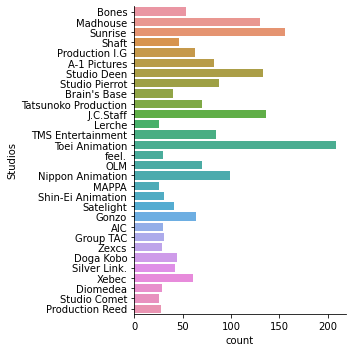

In [3]:
sb.catplot(y = 'Studios', data = TV_data[TV_data.groupby('Studios').Studios.transform('count') > 25], kind='count')

In [ ]:
TV_Studios_array=TV_data["Studios"].unique()
np.where(TV_Studios_array == TV_data["Studios"].iloc[27])[0][0]

In [6]:
print(type(int(TV_data["Episodes"].iloc[0])))
for i in range(len(TV_data)):
    if type(TV_data["Episodes"].iloc[i]) == str:
        TV_data["Episodes"].iloc[i] = 12

<class 'int'>


In [8]:
TV_data["Episodes"].info()

<class 'pandas.core.series.Series'>
Int64Index: 3681 entries, 0 to 9999
Series name: Episodes
Non-Null Count  Dtype
--------------  -----
3681 non-null   int64
dtypes: int64(1)
memory usage: 57.5 KB


In [9]:
source = TV_data['Source']
genres = TV_data['Genres']
score = TV_data['Score']
members = pd.DataFrame(TV_data['Members'])
fav = TV_data['Favorites']

In [10]:
TV_data.insert(loc=11, column='Fav%', value=round(TV_data['Favorites']*100/TV_data['Members'], 3))

In [11]:
source.unique()

array(['Manga', 'Visual novel', 'Light novel', 'Original', 'Web manga',
       'Novel', '4-koma manga', 'Card game', 'Book', 'Game', 'Other',
       'Unknown', 'Music', 'Picture book', 'Digital manga', 'Radio'],
      dtype=object)

Convert source to an int, total of 16 sources. Compress some sources together

0 - All manga + Picture book

1 - Novel, Light Novel, Book

2 - All game + Visual novel

3 - Other + Unknown

4 - Music + Radio

5 - Original

In [12]:
source_list = source.tolist() #list of sources based on index in Tv_data
source_list_unique = ["Manga", "Novel", "Game", "Other", "Audio", "Original"] #compresed source_reference list

In [13]:
a = [0] * len(TV_data)
for i in range(len(source_list)):
    if source_list[i] in ["Manga", "Web manga", "4-koma manga", "Digital manga", "Picture book"]:
        a[i] = source_list_unique.index("Manga")
    elif source_list[i] in ["Visual novel", "Light novel", "Book"]:
        a[i] = source_list_unique.index("Novel")
    elif source_list[i] in ["Card game", "Game", "Visual novel"]:
        a[i] = source_list_unique.index("Game")
    elif source_list[i] in ["Other", "Unknown"]:
        a[i] = source_list_unique.index("Other")
    elif source_list[i] in ["Radio", "Music"]:
        a[i] = source_list_unique.index("Audio")
    elif source_list[i] == "Original":
        a[i] = source_list_unique.index("Original")
TV_data["Source_reference"] = a

C:\Users\ezrak\AppData\Local\Temp\ipykernel_17336\1459102385.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TV_data["Source_reference"] = a


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree 

def decTree(y, x, depth):
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2)    
    dectree = DecisionTreeClassifier(max_depth = depth)
    dectree.fit(X_train, Y_train)
    Y_train_pred = dectree.predict(X_train)
    Y_test_pred = dectree.predict(X_test)
    cm = confusion_matrix(Y_train, Y_train_pred)
    TP = cm[1][1]/(cm[1][1] + cm[1][0])
    FP = cm[0][1]/(cm[0][1] + cm[0][0])
    cm1 = confusion_matrix(Y_test, Y_test_pred)
    TP1 = cm1[1][1]/(cm1[1][1] + cm1[1][0])
    FP1 = cm1[0][1]/(cm1[0][1] + cm1[0][0])
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, Y_train))
    #print("True Positive Rate \t:", TP)
    #print("False Positive Rate\t:", FP)
    print()
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, Y_test))
    #print("True Positive Rate \t:", TP1)
    #print("False Positive Rate\t:", FP1)
    print()
    f, axes = plt.subplots(1, 2, figsize=(24, 48))
    sb.heatmap(confusion_matrix(Y_train, Y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(Y_test, Y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    f = plt.figure(figsize=(48,48))
    plot_tree(dectree, filled=True, rounded=True, 
              feature_names="Fav%", 
              class_names=["0","1","2","3","4","5"])

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.4592391304347826

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.45454545454545453



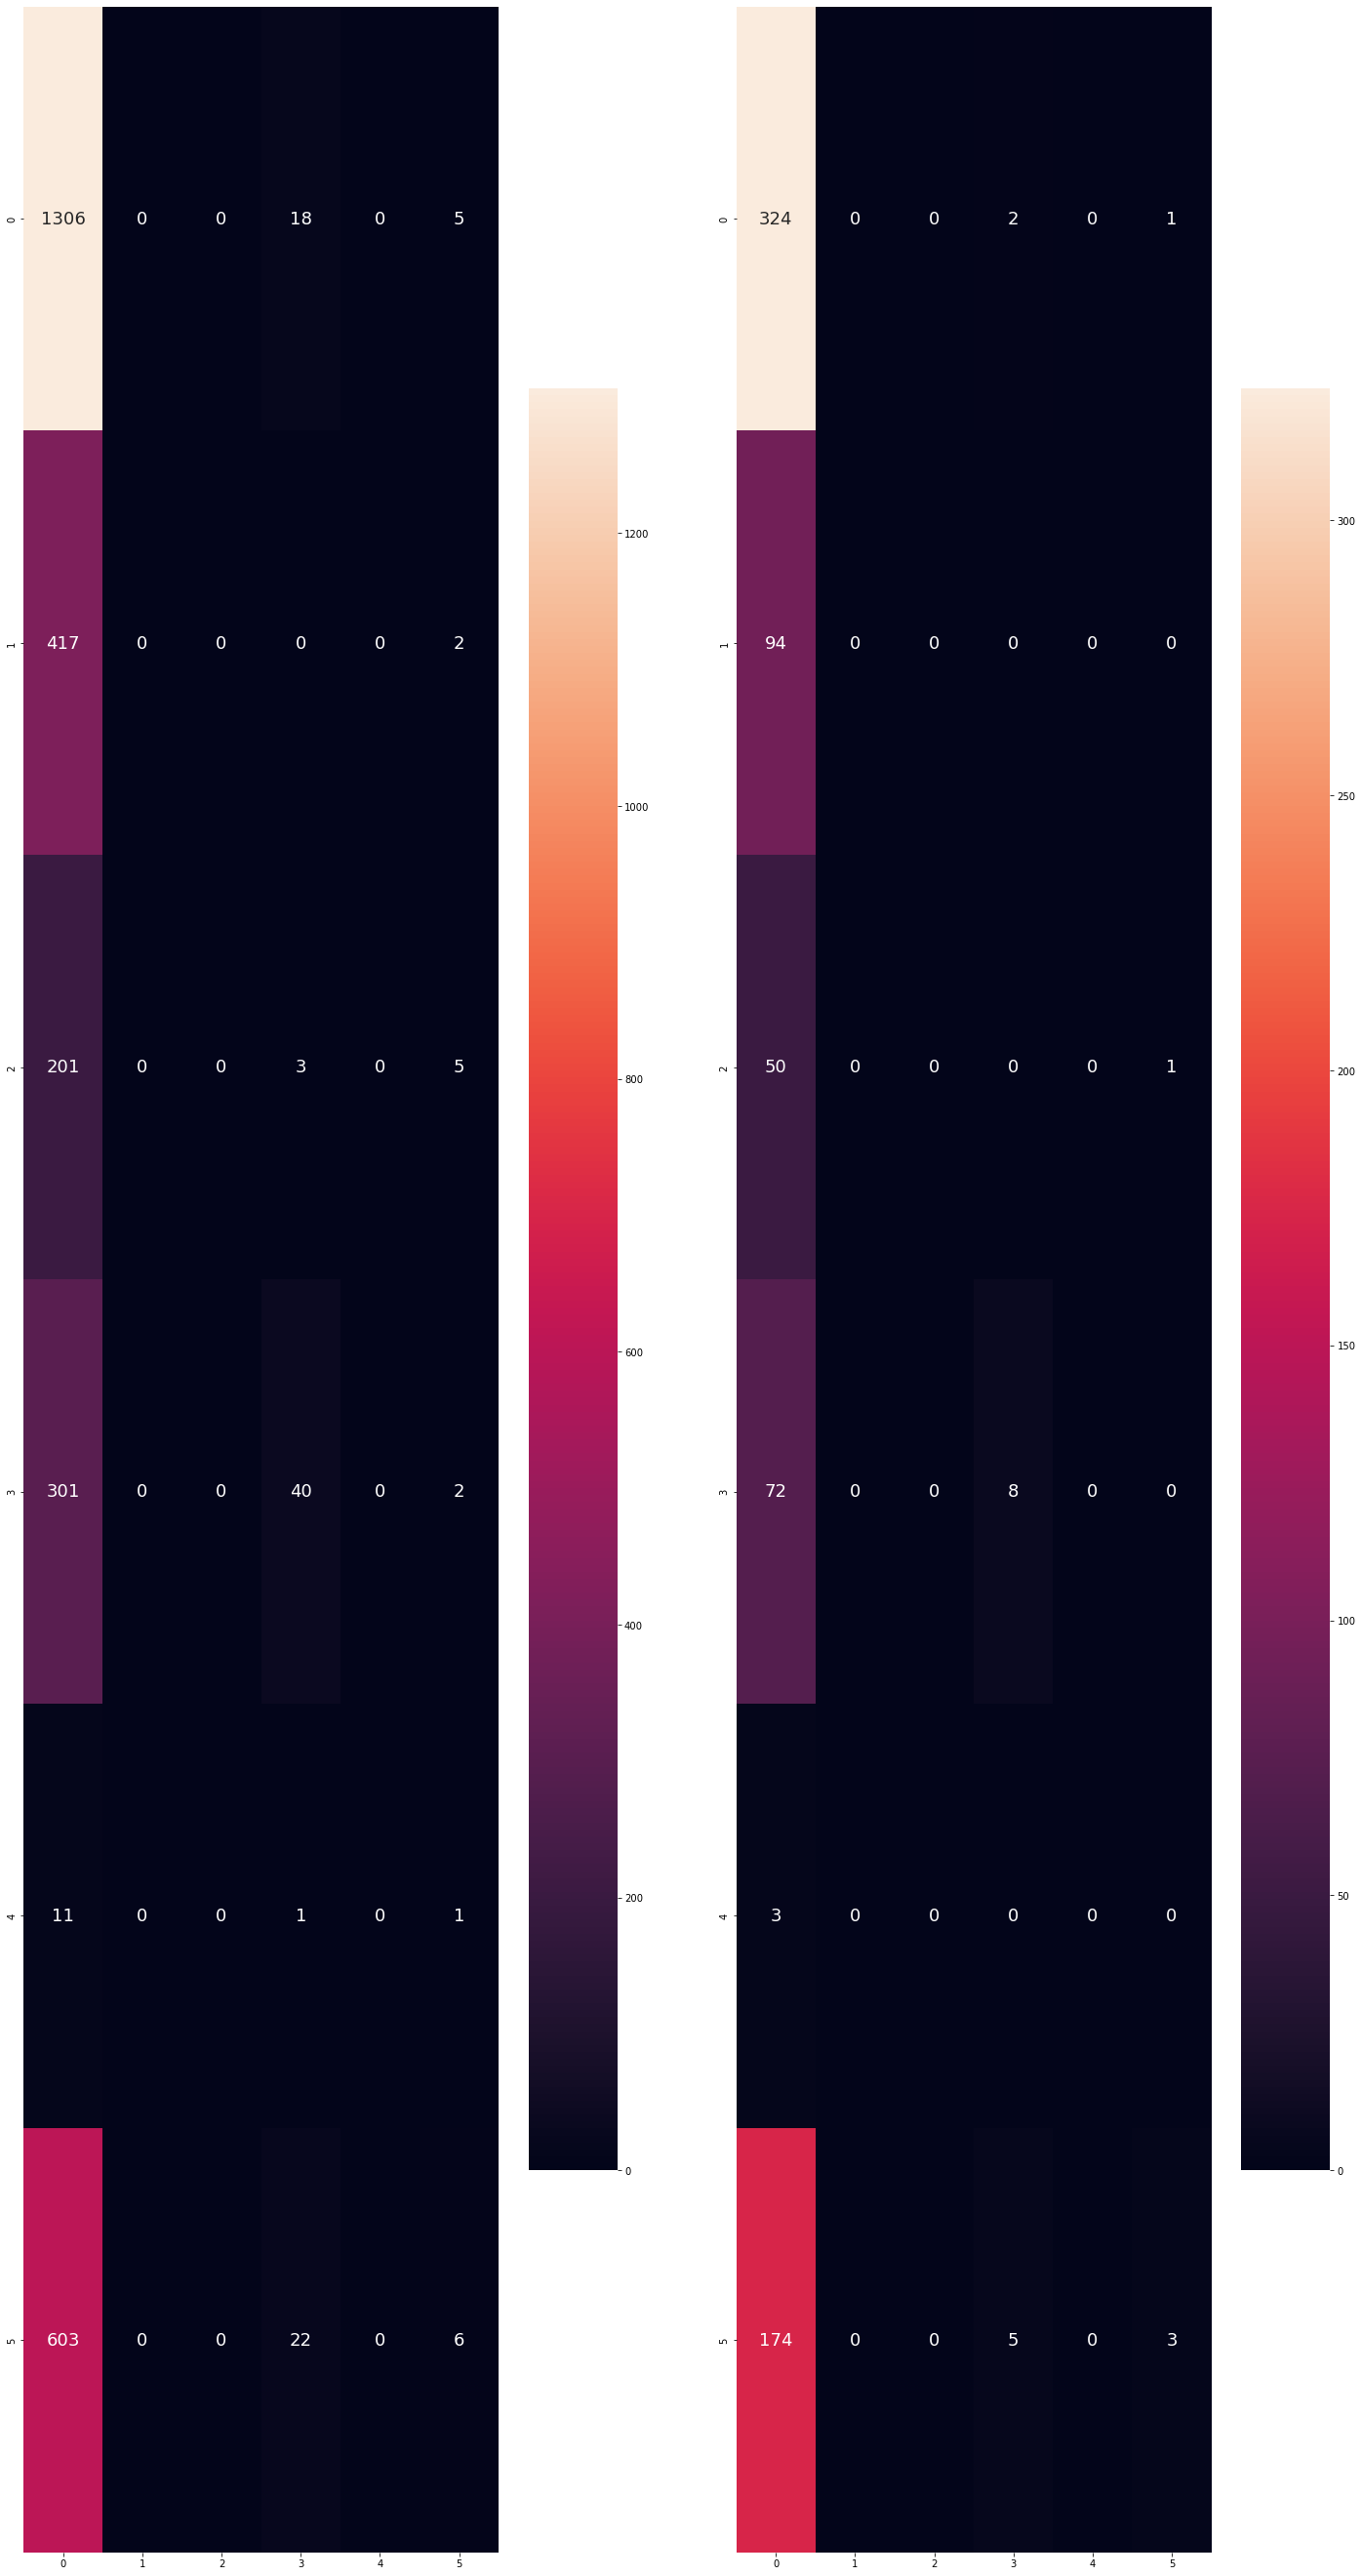

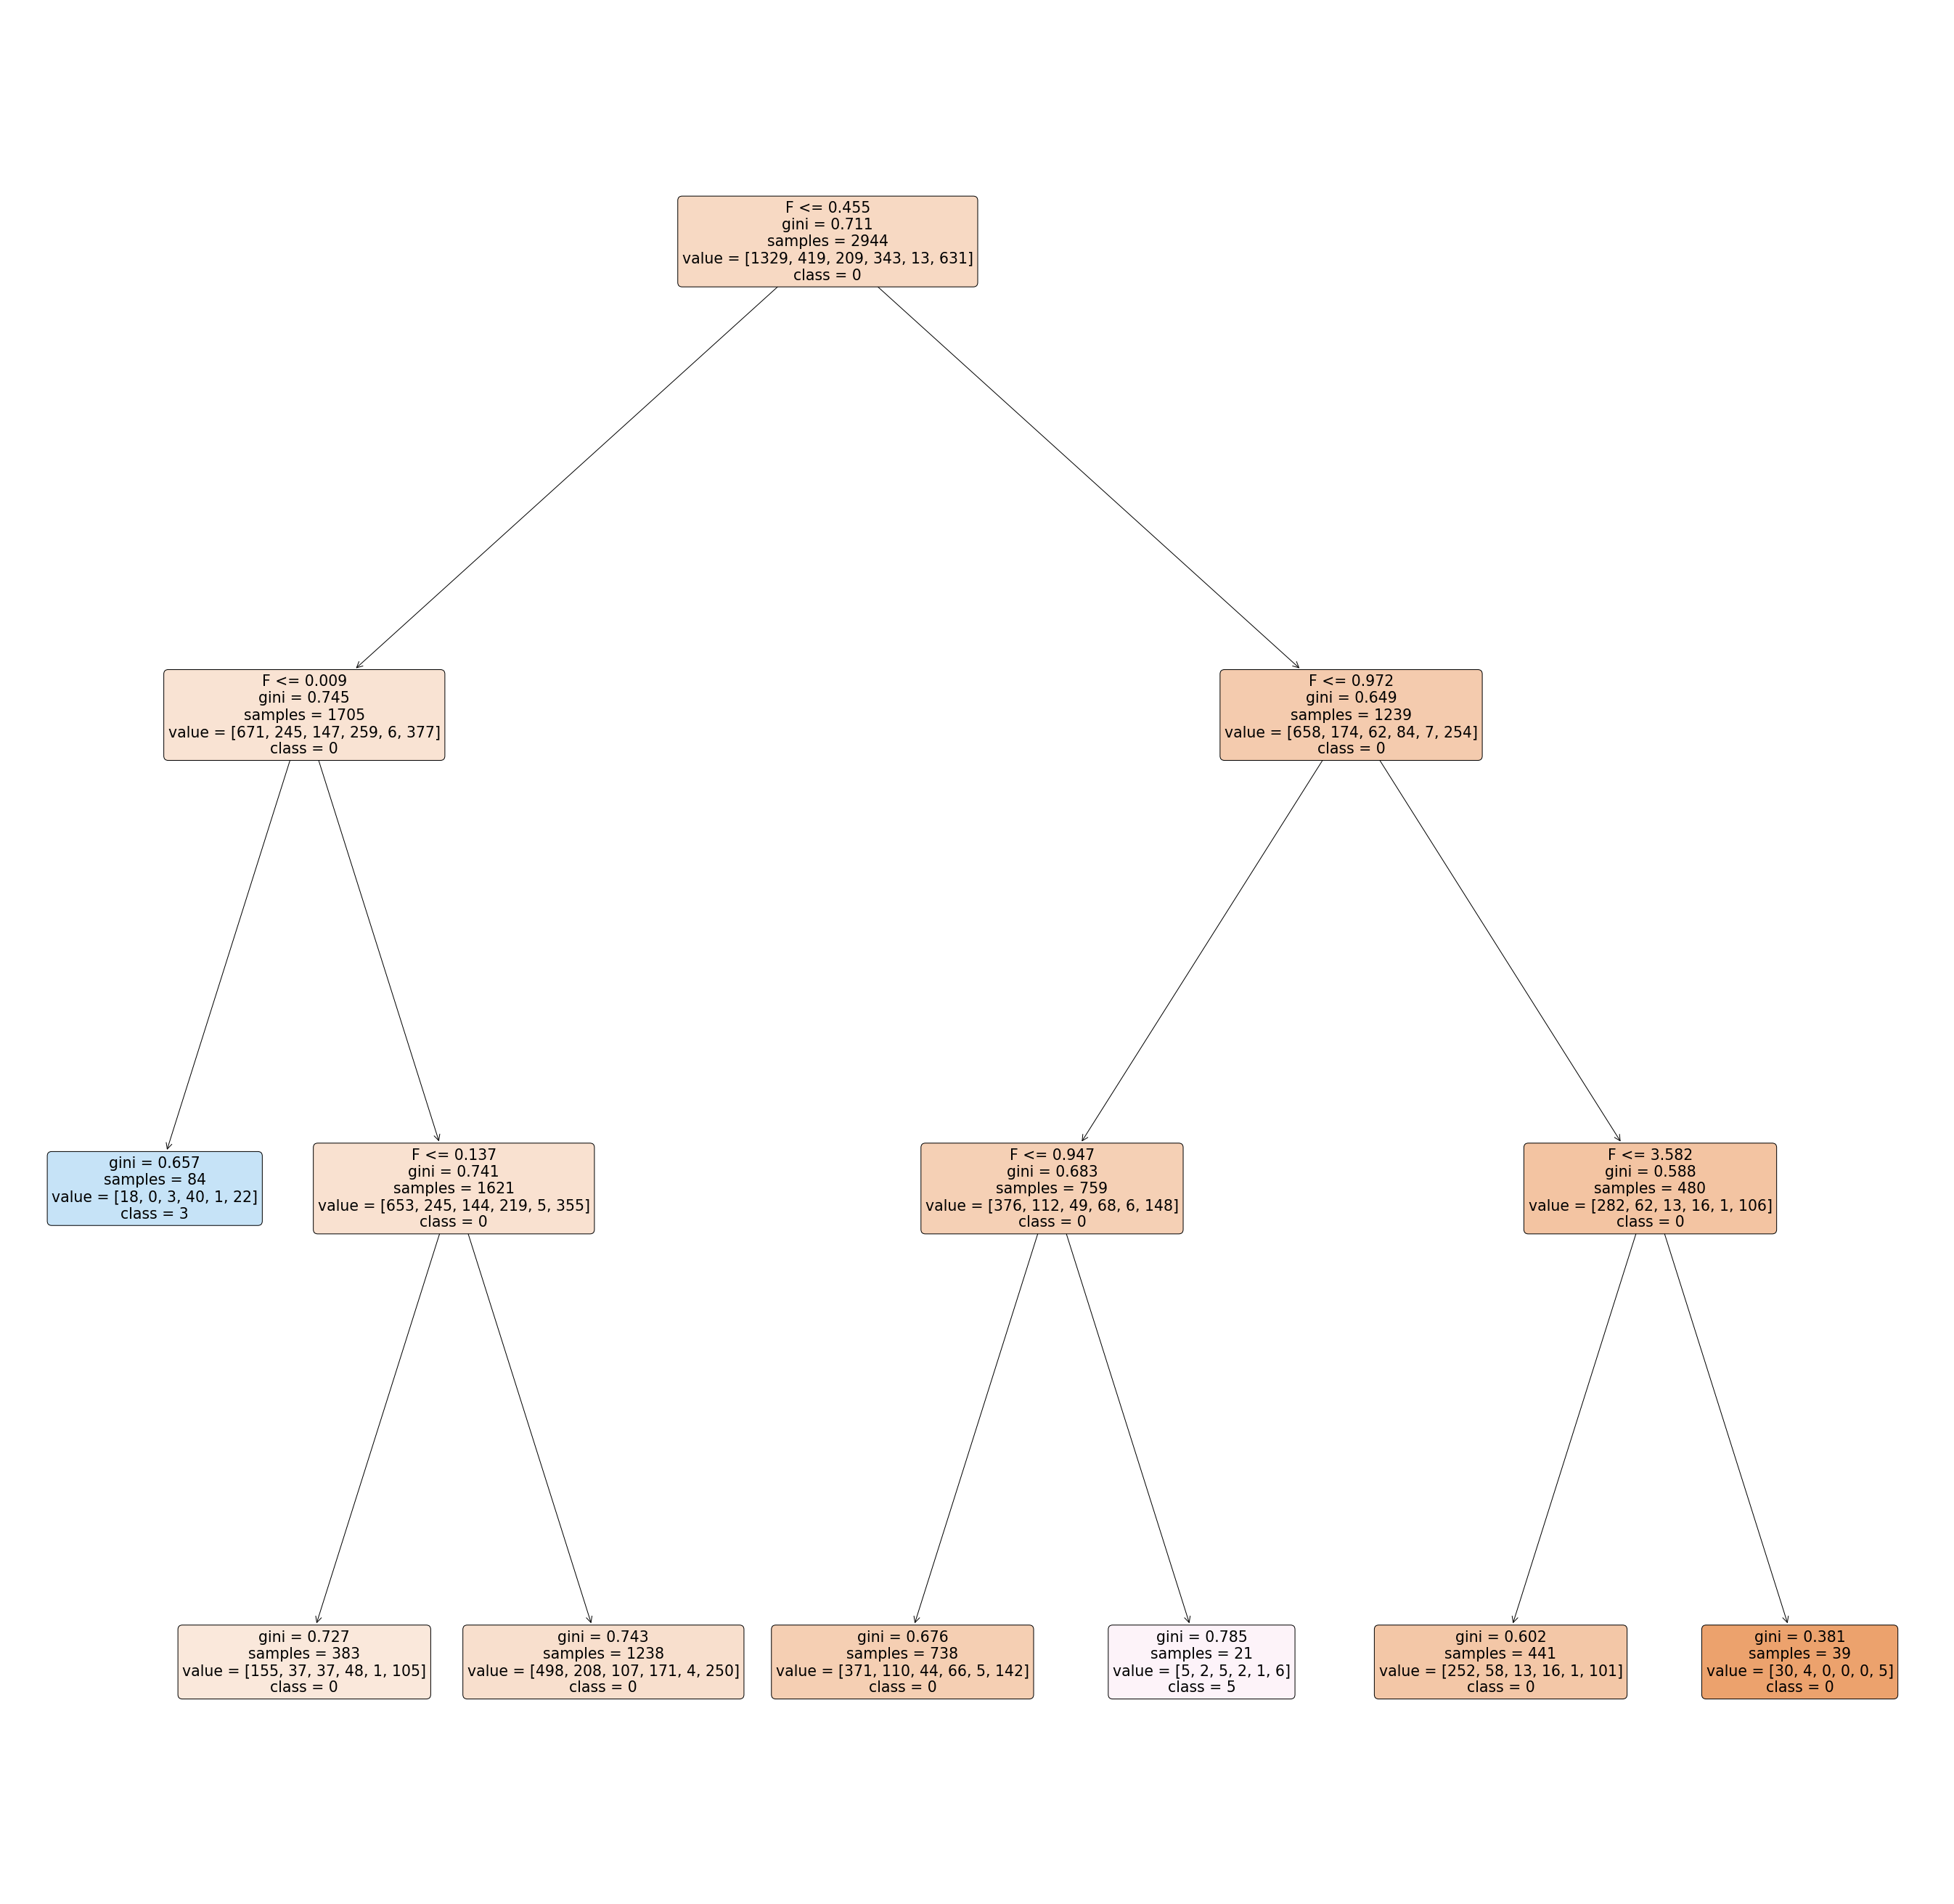

In [15]:
decTree(TV_data["Source_reference"].to_numpy().reshape(-1,1),TV_data["Fav%"].to_numpy().reshape(-1,1),3)

In [16]:
genres_list_unique = [0] * 100
index = 0;
for i in range(len(genres)):
    temp_list = genres.iloc[i].split(",")
    for element in temp_list:
        if(element.strip() not in genres_list_unique):
            genres_list_unique[index] = element.strip()
            index += 1
genres_list_unique = [i for i in genres_list_unique if i != 0] 
genres_list_unique.insert(0, "Null") #genres_list_unique contains all possible genre, first index is NULL(no genre)

In [17]:
a = [0] * len(TV_data)
b = [0] * len(TV_data)
for i in range(len(TV_data)):
    word = TV_data["Genres"].iloc[i].split(",")
    a[i] = genres_list_unique.index(word[0].strip())
    if(len(word)>1):
        b[i] = genres_list_unique.index(word[1].strip())

In [18]:
TV_data["Genre_reference_1"] = a
TV_data["Genre_reference_2"] = b
TV_data

C:\Users\ezrak\AppData\Local\Temp\ipykernel_17336\3427796180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TV_data["Genre_reference_1"] = a
C:\Users\ezrak\AppData\Local\Temp\ipykernel_17336\3427796180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TV_data["Genre_reference_2"] = b


,Anime Title,Type,Episodes,Aired,Producers,Studios,Source,Genres,Score,Members,Favorites,Fav%,Source_reference,Genre_reference_1,Genre_reference_2
0,Fullmetal Alchemist: Brotherhood,TV,12,"Apr 5, 2009 to Jul 4, 2010","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,"Action, Military, Adventure, Comedy, Drama, Ma...",9.22,2025613,167812,8.285,0,1,2
1,Steins;Gate,TV,12,"Apr 6, 2011 to Sep 14, 2011","Frontier Works, Media Factory, Movic, AT-X, Ka...",White Fox,Visual novel,"Thriller, Sci-Fi",9.12,1636151,139909,8.551,1,9,10
2,Gintama°,TV,12,"Apr 8, 2015 to Mar 30, 2016","TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,"Action, Comedy, Historical, Parody, Samurai, S...",9.11,363879,10353,2.845,0,1,4
3,Hunter x Hunter (2011),TV,12,"Oct 2, 2011 to Sep 24, 2014","VAP, Nippon Television Network, Shueisha",Madhouse,Manga,"Action, Adventure, Fantasy, Shounen, Super Power",9.11,1459320,130492,8.942,0,1,3
5,Gintama',TV,12,"Apr 4, 2011 to Mar 26, 2012","TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",Sunrise,Manga,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",9.08,337198,6013,1.783,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,Barom One,TV,12,"Dec 7, 2002 to Mar 22, 2003",AT-X,E&G Films,Manga,"Action, Sci-Fi, Supernatural, Shounen",5.25,1576,1,0.063,0,1,10
9983,Kurayami Santa,TV,12,"Jul 5, 2015 to Sep 27, 2015",NaN,ILCA,Original,"Historical, Supernatural",5.25,2392,6,0.251,5,11,19
9985,Omae wa Mada Gunma wo Shiranai,TV,12,"Apr 2, 2018 to Jun 18, 2018",TOHO animation,Asahi Production,Web manga,"Comedy, School",5.25,11760,2,0.017,0,4,24
9987,Peeping Life,TV,12,"May 14, 2009 to Aug 11, 2009",CoMix Wave Films,NaN,Original,"Slice of Life, Comedy",5.25,2481,3,0.121,5,18,4


In [19]:
TV_data["Genre_reference_1"].unique()

array([ 1,  9,  5, 18, 15,  4,  3, 10, 26, 16, 28, 27, 31, 39, 20,  7, 33,
        8, 17, 23,  2, 22, 11, 36, 35, 25, 24, 38, 40,  6, 14, 19, 29, 12,
       34], dtype=int64)

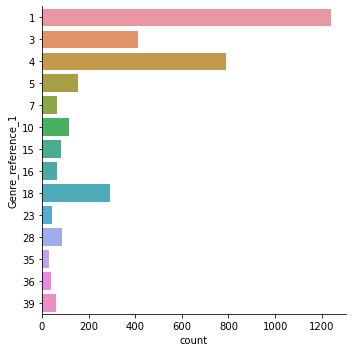

In [20]:
sb.catplot(y = 'Genre_reference_1', data = TV_data[TV_data.groupby('Genre_reference_1').Studios.transform('count') > 25], kind='count')

In [21]:
c = [0] * len(TV_data)
for i  in range(len(TV_data)):
    temp = TV_data["Aired"].iloc[i][:3]
    if temp == 'Jan' or temp == 'Feb' or temp == 'Mar':
        c[i] = 1
    elif temp == 'Apr' or temp == 'May' or temp == 'Jun':
        c[i] = 2
    elif temp == 'Jul' or temp == 'Aug' or temp == 'Sep':
        c[i] = 3
    else:
        c[i] = 4
TV_data["Season"] = c
TV_data

C:\Users\ezrak\AppData\Local\Temp\ipykernel_17336\436610766.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TV_data["Season"] = c


,Anime Title,Type,Episodes,Aired,Producers,Studios,Source,Genres,Score,Members,Favorites,Fav%,Source_reference,Genre_reference_1,Genre_reference_2,Season
0,Fullmetal Alchemist: Brotherhood,TV,12,"Apr 5, 2009 to Jul 4, 2010","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,"Action, Military, Adventure, Comedy, Drama, Ma...",9.22,2025613,167812,8.285,0,1,2,2
1,Steins;Gate,TV,12,"Apr 6, 2011 to Sep 14, 2011","Frontier Works, Media Factory, Movic, AT-X, Ka...",White Fox,Visual novel,"Thriller, Sci-Fi",9.12,1636151,139909,8.551,1,9,10,2
2,Gintama°,TV,12,"Apr 8, 2015 to Mar 30, 2016","TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,"Action, Comedy, Historical, Parody, Samurai, S...",9.11,363879,10353,2.845,0,1,4,2
3,Hunter x Hunter (2011),TV,12,"Oct 2, 2011 to Sep 24, 2014","VAP, Nippon Television Network, Shueisha",Madhouse,Manga,"Action, Adventure, Fantasy, Shounen, Super Power",9.11,1459320,130492,8.942,0,1,3,4
5,Gintama',TV,12,"Apr 4, 2011 to Mar 26, 2012","TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",Sunrise,Manga,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",9.08,337198,6013,1.783,0,1,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,Barom One,TV,12,"Dec 7, 2002 to Mar 22, 2003",AT-X,E&G Films,Manga,"Action, Sci-Fi, Supernatural, Shounen",5.25,1576,1,0.063,0,1,10,4
9983,Kurayami Santa,TV,12,"Jul 5, 2015 to Sep 27, 2015",NaN,ILCA,Original,"Historical, Supernatural",5.25,2392,6,0.251,5,11,19,3
9985,Omae wa Mada Gunma wo Shiranai,TV,12,"Apr 2, 2018 to Jun 18, 2018",TOHO animation,Asahi Production,Web manga,"Comedy, School",5.25,11760,2,0.017,0,4,24,2
9987,Peeping Life,TV,12,"May 14, 2009 to Aug 11, 2009",CoMix Wave Films,NaN,Original,"Slice of Life, Comedy",5.25,2481,3,0.121,5,18,4,2


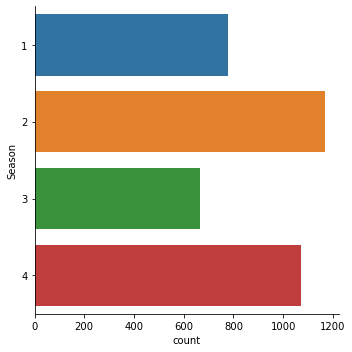

In [22]:
sb.catplot(y = 'Season', data = TV_data[TV_data.groupby('Season').Studios.transform('count') > 25], kind='count')

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.32235054347826086

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.31886024423337855



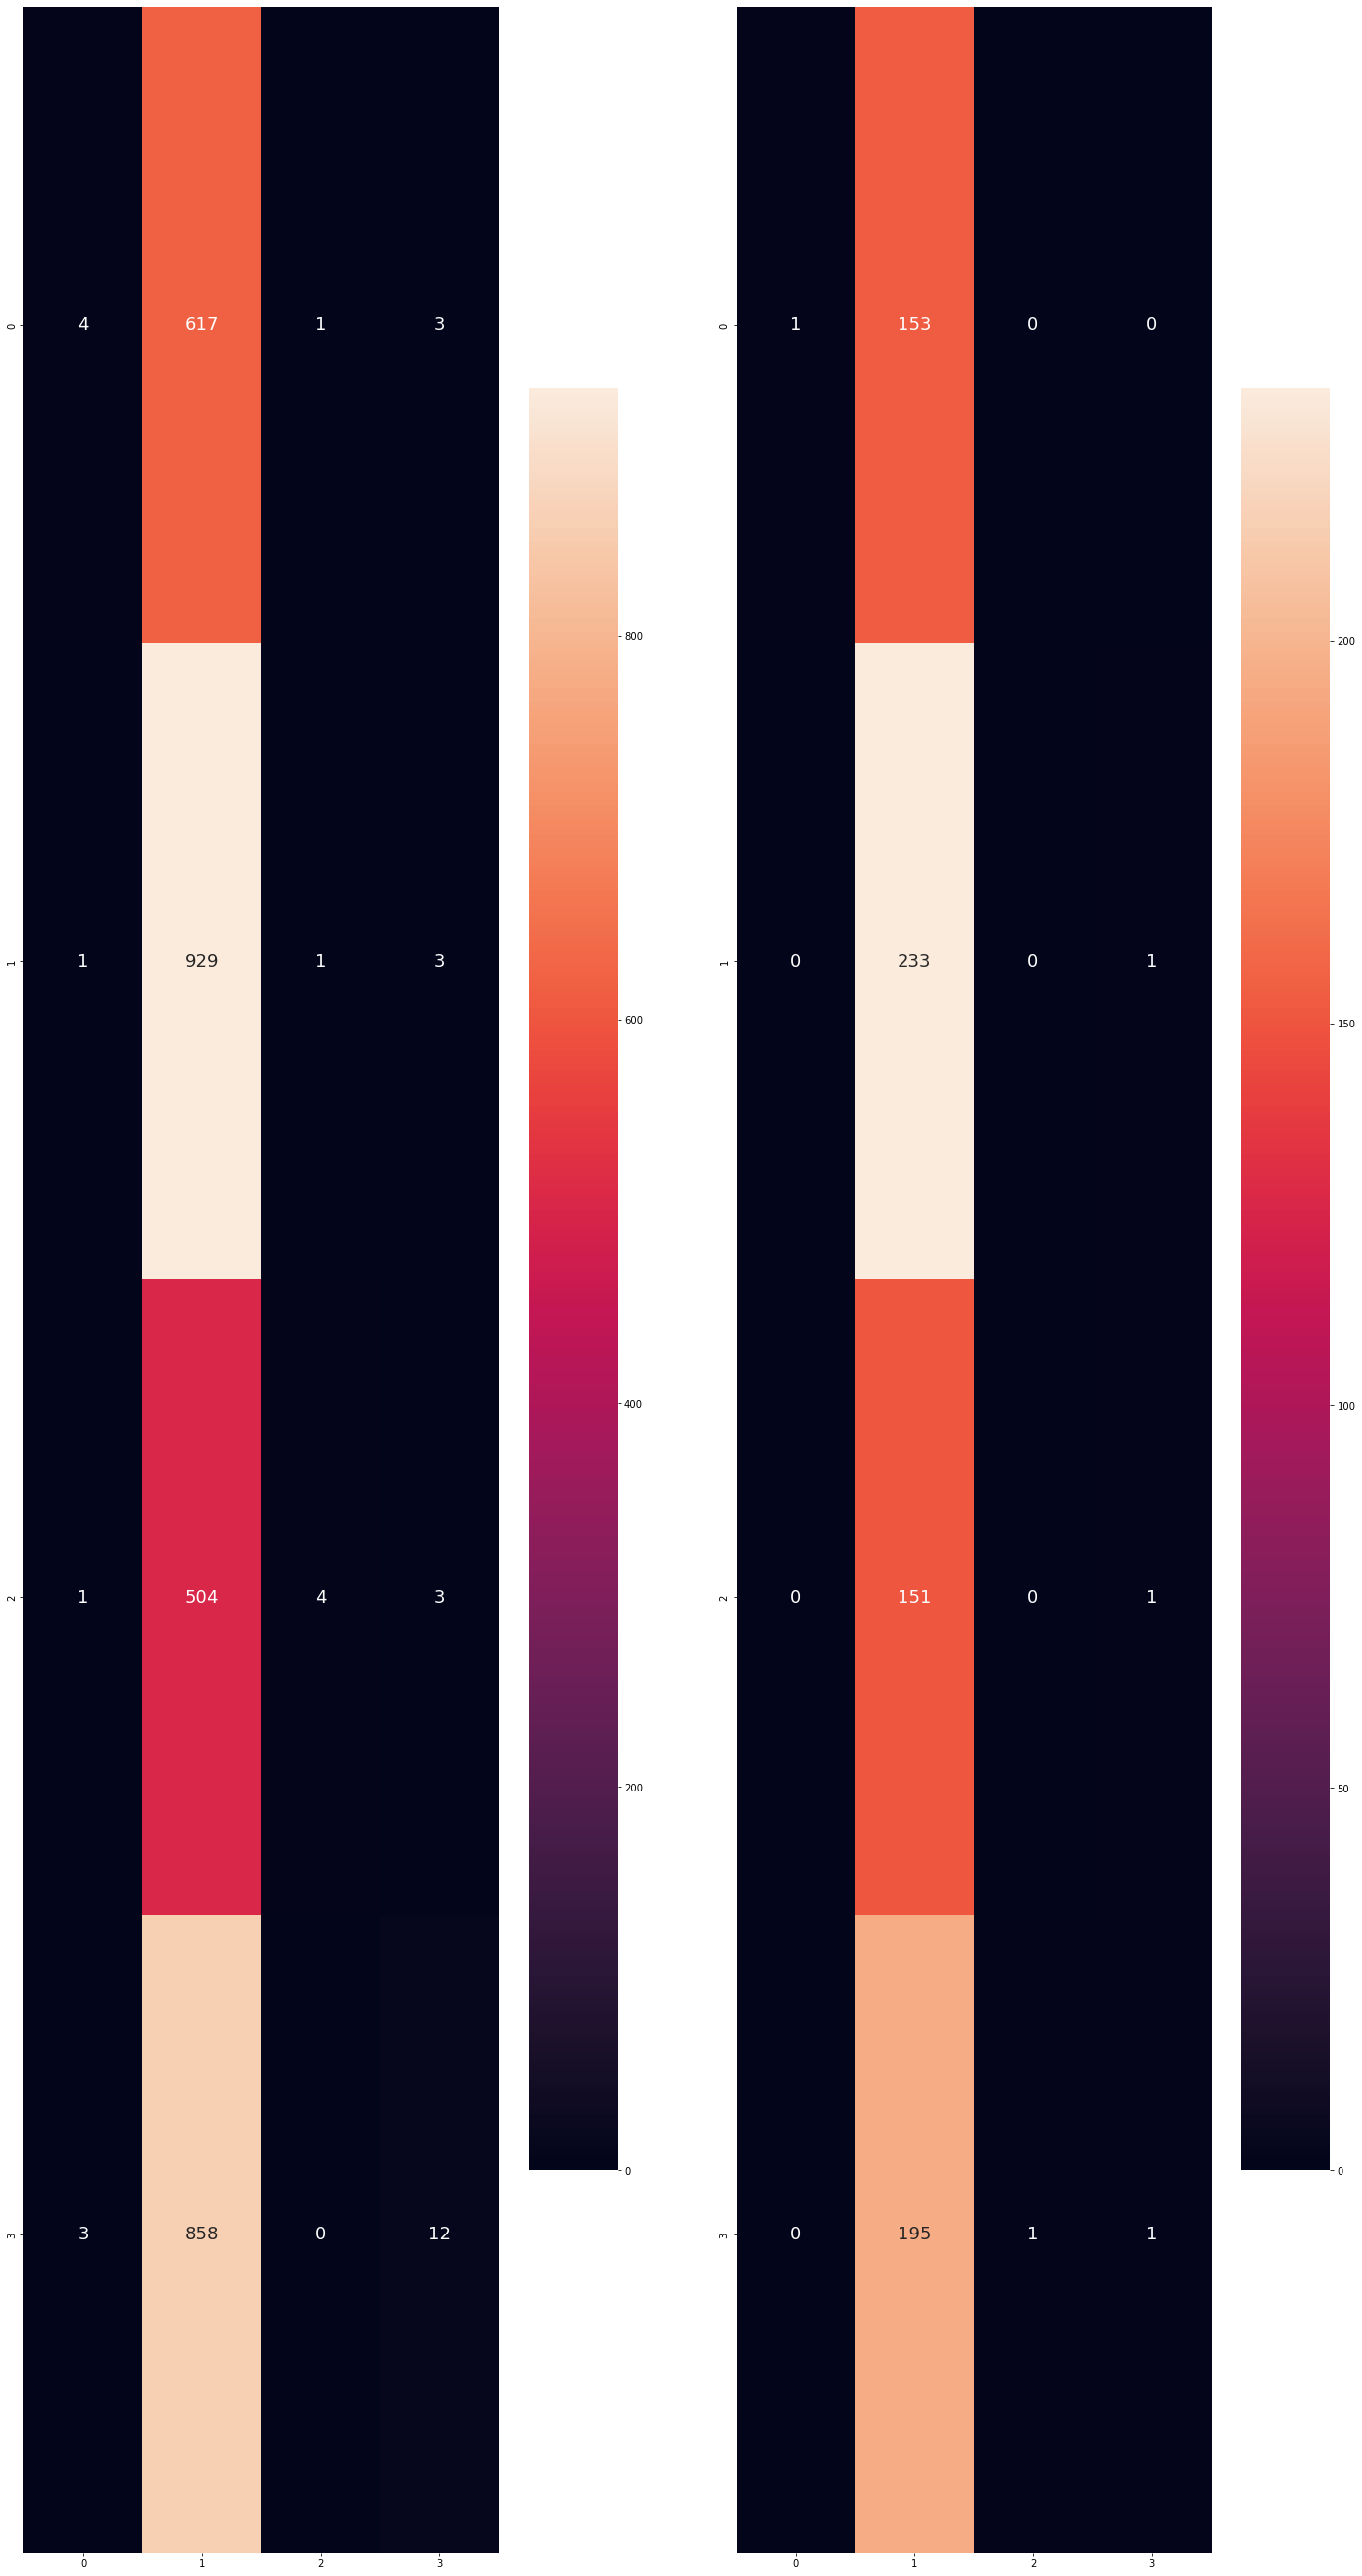

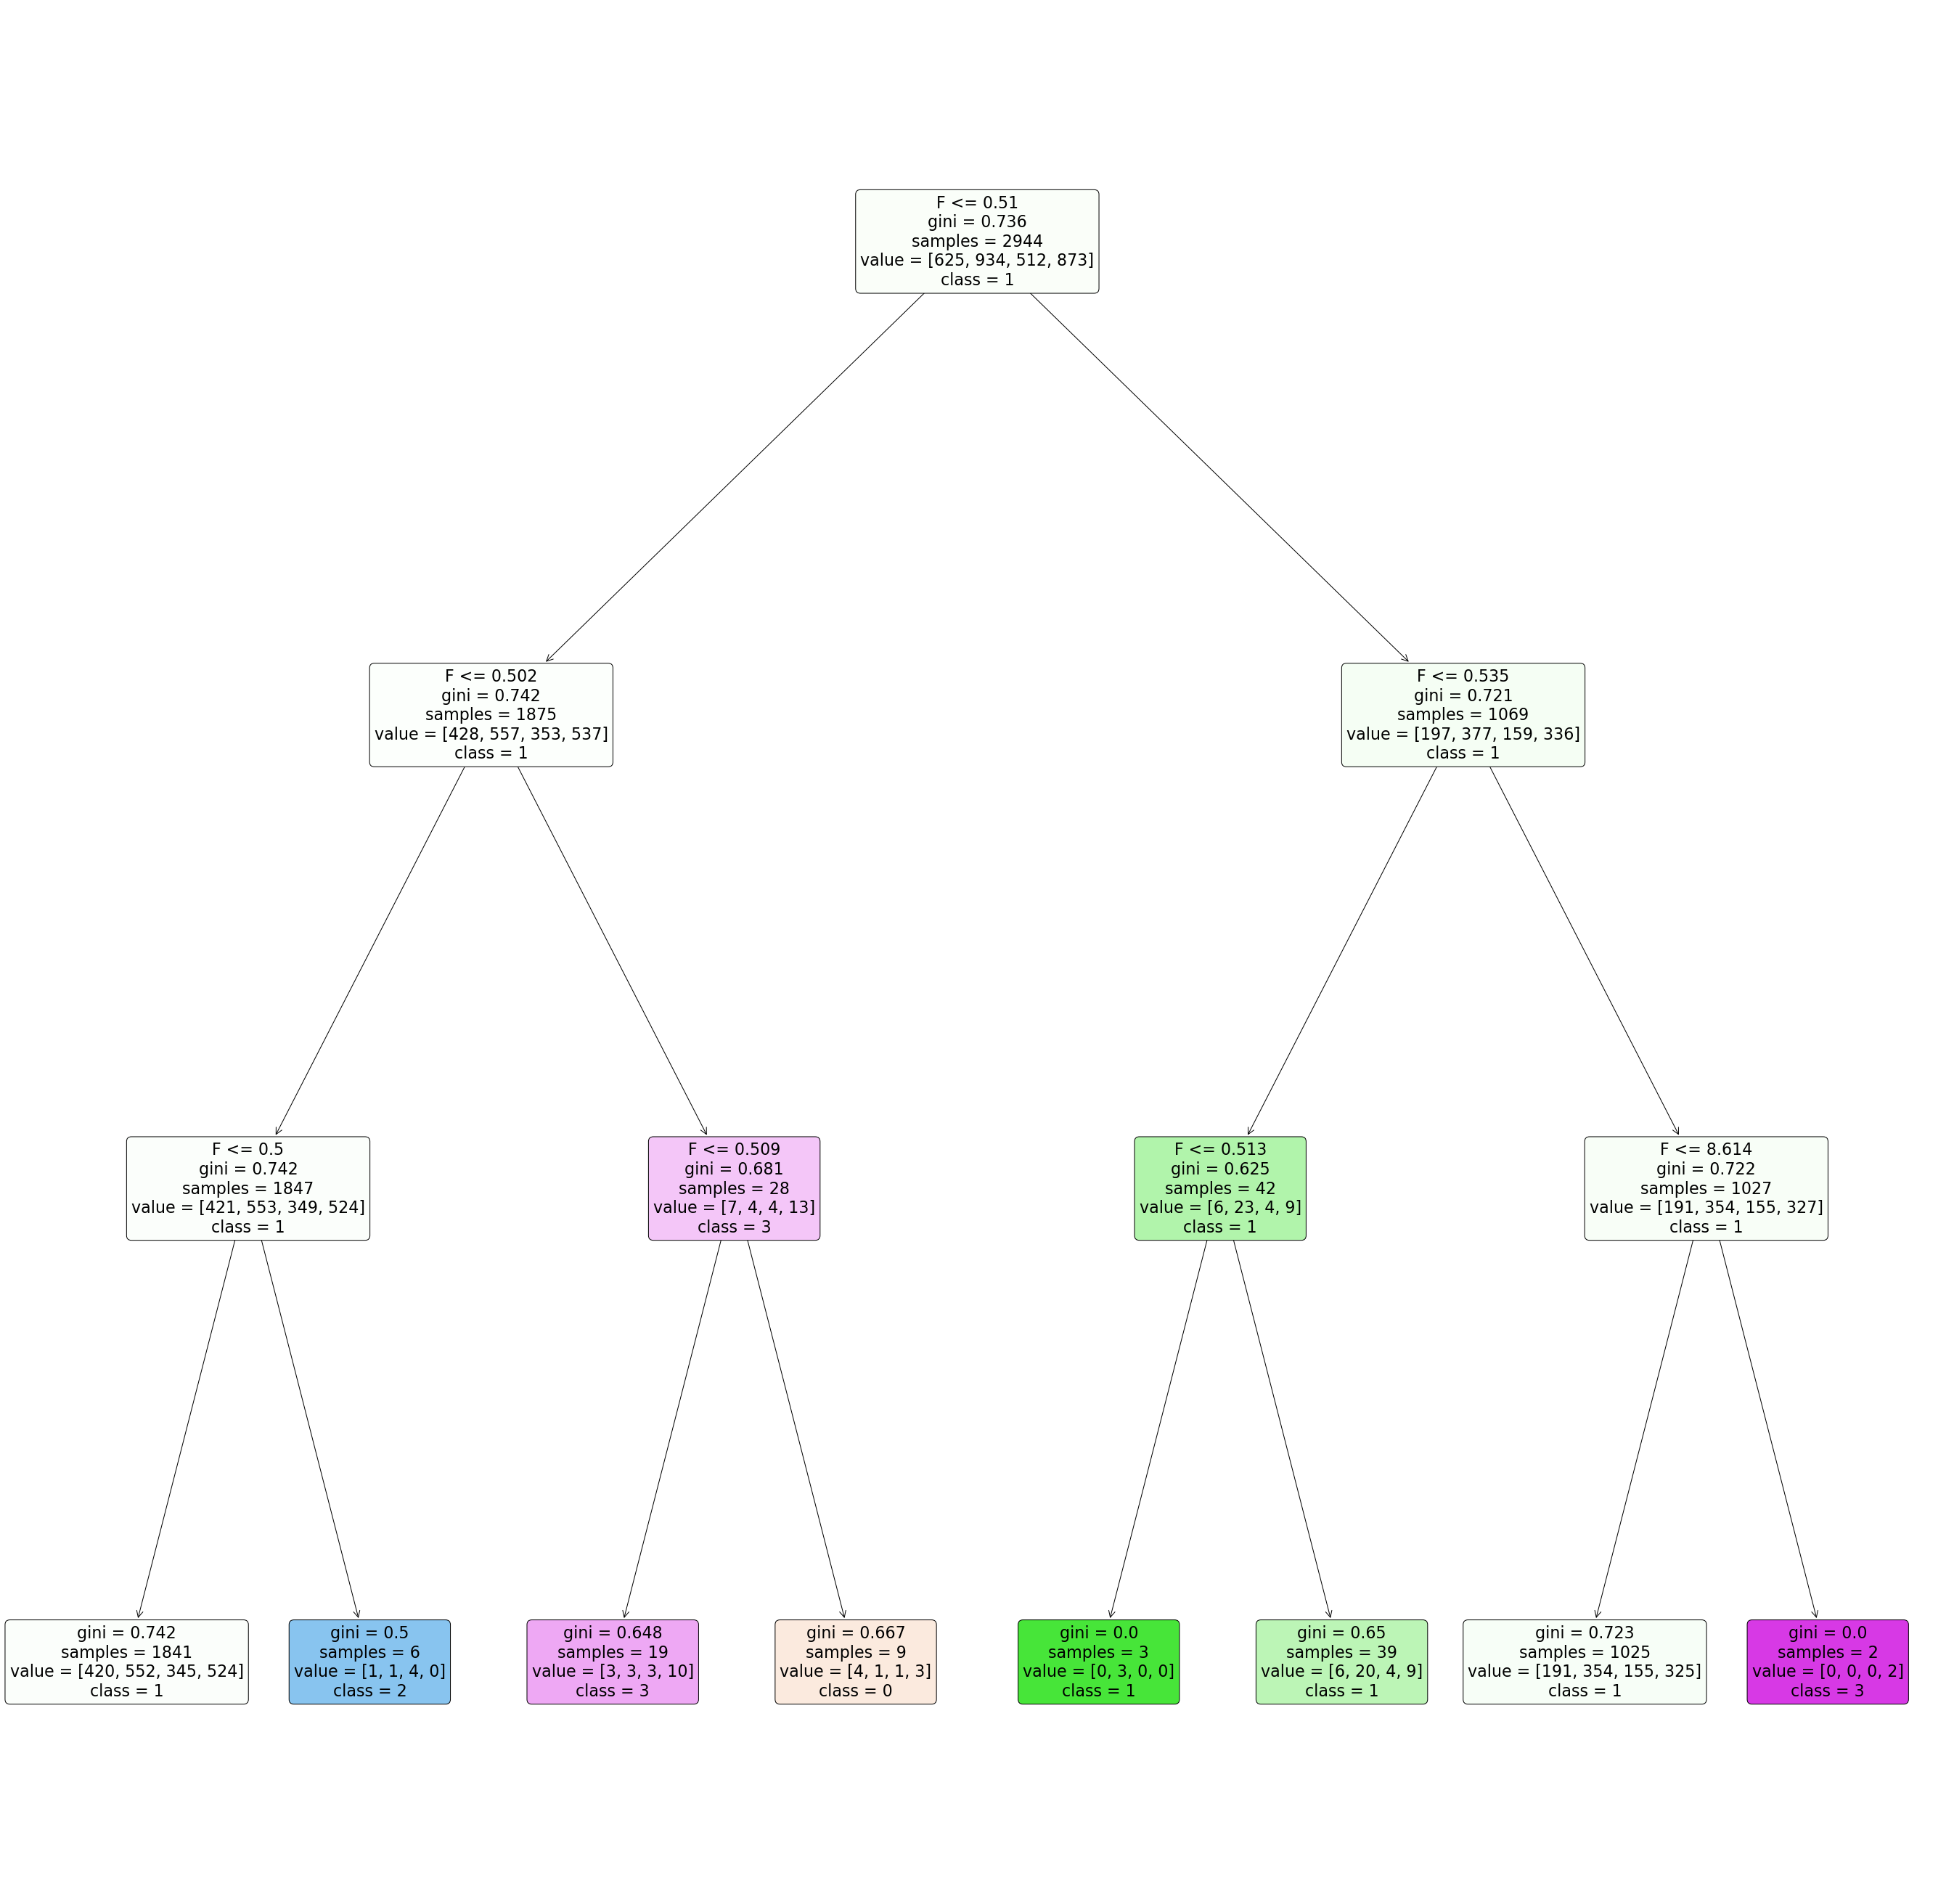

In [23]:
decTree(TV_data["Season"].to_numpy().reshape(-1,1),TV_data["Fav%"].to_numpy().reshape(-1,1),3)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X1 = TV_data["Genre_reference_1"].to_numpy().reshape(-1,1) #0.20 without
X2 = TV_data["Genre_reference_2"].to_numpy().reshape(-1,1) #0.18 without
X3 = TV_data["Season"].to_numpy().reshape(-1,1) #0.25 without
X4 = TV_data["Source_reference"].to_numpy().reshape(-1,1) ##0.12 without
X5 = TV_data['Members'].to_numpy().reshape(-1,1) #0.32 without (deg9)
X6 = TV_data['Episodes'].to_numpy().reshape(-1,1) #0.39 without, aka useless
X = np.concatenate((X1, X2, X3, X4, X5), axis=1) #0.39 with X1-5 deg2
y = TV_data["Score"]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

r_sq = model.score(X_poly, y)
print('R^2 score:', r_sq)


R^2 score: 0.3864726287875807


In [ ]:
type(TV_data["Season"])